In [15]:
import joblib
import scanpy as sc
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np

In [29]:
import palantir

In [2]:
model = joblib.load('../../3.9_wt_integrate/processed_data/11.16_pseudo_predict_model/11.18_lightGBM_pred.pkl')

In [5]:
extendAtlas=sc.read("../../important_processed_data/9.18_intergrate.h5ad")

In [7]:
extendAtlas.layers["counts"]

<781397x20664 sparse matrix of type '<class 'numpy.float64'>'
	with 2108201915 stored elements in Compressed Sparse Row format>

In [11]:
rf_gene=pd.read_csv("../../important_processed_data/10.29_rf_importance_gene.csv")
gene=rf_gene["gene"][rf_gene["importance"]>0.000008]

In [8]:

def formOsteoAdata(adata,missing_threshold=500,variableFeature="Default"):
    
    if isinstance(variableFeature,str):
        if variableFeature=="Default":
            variableFeature=pd.read_csv(highVarGeneFile,index_col=0)["0"].values
    if(len(variableFeature)-adata.var_names.isin(variableFeature).sum()>missing_threshold):
        raise ValueError("Too many missing gene! Please check data!")
        
    print("Total number of genes needed for mapping:",len(variableFeature))
    print(
        "Number of genes found in query dataset:",
        adata.var_names.isin(variableFeature).sum(),
    )
    missing_genes = [
        gene_id
        for gene_id in variableFeature
        if gene_id not in adata.var_names
    ]
    missing_gene_adata = sc.AnnData(
        X=csr_matrix(np.zeros(shape=(adata.n_obs, len(missing_genes))), dtype="float32"),
        obs=adata.obs.iloc[:, :1],
        var=missing_genes,
    )
    missing_gene_adata.var_names=missing_genes
    missing_gene_adata.layers["counts"] = missing_gene_adata.X
    if "PCs" in adata.varm.keys():
        del adata.varm["PCs"]
        
    adata_merged = sc.concat(
        [adata, missing_gene_adata],
        axis=1,
        join="outer",
        index_unique=None,
        merge="unique",
    )
    adata_merged = adata_merged[
        :, variableFeature
    ].copy()
    return(adata_merged)


In [16]:
extendAtlas=formOsteoAdata(extendAtlas,missing_threshold=500,variableFeature=gene)

Total number of genes needed for mapping: 2146
Number of genes found in query dataset: 2142


/home/zhanglab/mambaforge/envs/py310/lib/python3.10/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):
/home/zhanglab/mambaforge/envs/py310/lib/python3.10/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/zhanglab/mambaforge/envs/py310/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [20]:
extendAtlas.layers["counts"]

<781397x2146 sparse matrix of type '<class 'numpy.float64'>'
	with 727474458 stored elements in Compressed Sparse Row format>

In [21]:
dpt=model.predict(extendAtlas.layers["counts"])

In [25]:
extendAtlas.obs["dpt_time"]=dpt

In [35]:
pd.DataFrame(dpt).to_csv("../../important_processed_data/24.1.4_dpt.csv")

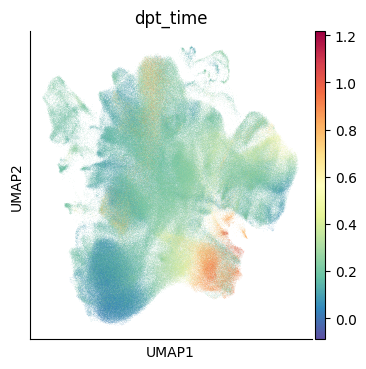

In [31]:
sc.pl.umap(extendAtlas,color="dpt_time")

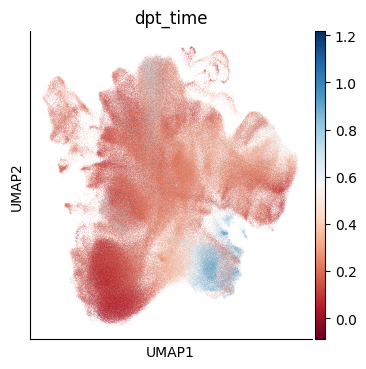

In [34]:
sc.pl.umap(extendAtlas,color="dpt_time",cmap="RdBu")

/home/zhanglab/mambaforge/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhanglab/mambaforge/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


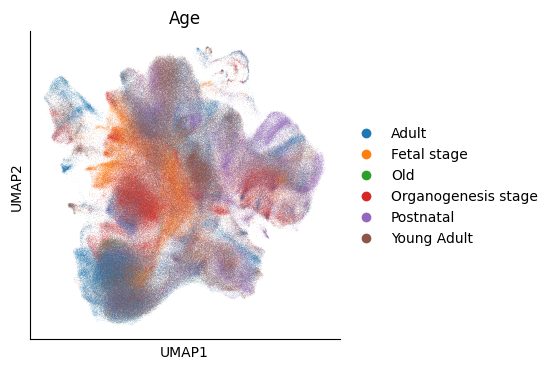

In [32]:
sc.pl.umap(extendAtlas,color="Age")